## Importing DataSet

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


class HeartRateDataset(Dataset):
    def __init__(self, data_path, frame_length, pixel_size):
        self.data_path = data_path
        self.frame_length = frame_length
        self.pixel_size = pixel_size
        self.video_paths, self.labels = self._read_data()

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, index):
        self.index = index
        video_path = self.video_paths[index]
        label = self.labels[index]
        # print(video_path, index, label)
        clips, clips_labels = self._load_video(video_path, label)
        return clips, clips_labels

    def _read_data(self):
        video_paths = []
        labels = []
        # Excluding Some Videos for testing Purposes
        # excluded_directory = []
    #     excluded_directory = [              # subject1, 2, 3 & 4 shouldn't be in this list because of them all others are excluded too
    #     "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject8",
    #     "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject9",
    #     "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject17",
    #     "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject23",
    #     "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject27",
    #     "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject31"
    # ]
# Skipping /content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject17/vid.avi due to being in an excluded directory
# Skipping /content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject23/vid.avi due to being in an excluded directory
# Skipping /content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject31/vid.avi due to being in an excluded directory
# Skipping /content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject8/vid.avi due to being in an excluded directory
# Skipping /content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject9/vid.avi due to being in an excluded directory

        for root, _, files in os.walk(self.data_path):
          if "vid.avi" in files and "ground_truth.txt" in files:
              video_path = os.path.join(root, "vid.avi")
              ground_truth_file = os.path.join(root, "ground_truth.txt")

              # Check if the current root directory should be excluded
              if any(excluded_dir in root for excluded_dir in excluded_directory):
                # video_path = os.path.join(root, "vid.avi")
                # ground_truth_file = os.path.join(root, "ground_truth.txt")
                print(f"Skipping {video_path} due to being in an excluded directory")
                continue
              else:
                with open(ground_truth_file, 'r') as f:
                    # Read the first two lines
                    lines = f.readlines()
                    if len(lines) >= 2:
                        # Split the second line into numerical values
                        label_line = lines[1].strip()
                        label_values = [float(val) for val in label_line.split()]
                        video_paths.append(video_path)
                        labels.append(label_values)
                    else:
                        print(f"Skipping {video_path} due to missing second line in ground_truth.txt")
        return video_paths, labels


    def _load_video(self, video_path, label):
        cap = cv2.VideoCapture(video_path)
        video_frames = []
        frame_indices = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            # plt.subplot(3,3,ret);plt.imshow(frame)
            if not ret:
                break
            video_frames.append(frame)
            frame_indices.append(frame_count)
            frame_count += 1
            # plt.subplot(50,50,frame_count);plt.imshow(frame)
        cap.release()

        # print(frame_indices)
        # Randomly choose 16 frame indices

        if len(frame_indices) < self.frame_length:
          print("Error: Not enough frames for sampling.")
          return 0, 0  # Return None to indicate that no clips were generated

        selected_indices = np.random.choice(frame_indices, size=self.frame_length, replace=False)
        # Convert labels to a NumPy array
        labels_array = np.array(label)
        # Use the selected indices to retrieve corresponding heart rate labels
        selected_labels = labels_array[selected_indices]  # Select the appropriate columns
        selected_frames = [video_frames[i] for i in selected_indices]
        selected_frames = self._preprocess_frames(selected_frames)
        video_tensor = torch.tensor(selected_frames)  # Convert NumPy array to PyTorch tensor
        # self._imshow_frames(selected_frames)

        if len(video_tensor) < self.frame_length:
          num_repeats = self.frame_length // len(video_tensor) + 1
          video_tensor = video_tensor.repeat(num_repeats, 1, 1, 1)

        # Create clips with the selected frames and corresponding labels
        clips = []
        clips_labels = []
        for i in range(len(selected_frames) - self.frame_length + 1):
            clip = selected_frames[i:i + self.frame_length]
            clip_labels = selected_labels[i:i + self.frame_length]
            # clips.append(clip)
            clips.append(clip)  # Include the selected labels for each clip
            clips_labels.append(clip_labels)

        self._imshow_clips(clips, clips_labels)
        return clips, clips_labels

    def _preprocess_frames(self, video_frames):
        # Resize and normalize frames
        processed_frames = [cv2.resize(frame, (self.pixel_size, self.pixel_size)) for frame in video_frames]
        processed_frames = np.array(processed_frames, dtype=np.float32)
        processed_frames /= 255.0  # Normalize to [0, 1]
        return processed_frames

    def _imshow_frames(self, video_frames):
        # Resize and normalize frames
        selected_frames = video_frames * 255.0
        # Save the frames to a directory
        output_dir = "/content/SAVE_FRAMES/View_Frames"
        os.makedirs(output_dir, exist_ok=True)
        for idx, frame in enumerate(selected_frames):
            frame_filename = os.path.join(output_dir, f"frame_{idx}.png")
            plt.imshow(frame)
            cv2.imwrite(frame_filename, frame)
        # Visualize frames outside the loop
        num_visualize = min(3, len(selected_frames))  # Ensure not to exceed available frames
        visualize_filenames = np.random.choice(os.listdir(output_dir), size=num_visualize, replace=False)
        print("Filenames in output directory:", visualize_filenames)
        for filename in visualize_filenames:
            frame_path = os.path.join(output_dir, filename)
            frame = cv2.imread(frame_path)
            plt.imshow(frame)
            plt.title(f"Selected Frame: {filename}")
            plt.show()

    def _imshow_clips(self, clips, labels):
      output_dir = "/content/SAVE_FRAMES/View_Clips"
      os.makedirs(output_dir, exist_ok=True)

      for idx, (clip, label) in enumerate(zip(clips, labels)):
          clip_frames = [frame * 255.0 for frame in clip]  # Multiply each frame by 255.0
          clip_filename = os.path.join(output_dir, f"Clip_{self.index}_{idx}.avi")  # Include self.index in the filename

          clip_height, clip_width = clip_frames[0].shape[:2]
          fourcc = cv2.VideoWriter_fourcc(*'XVID')
          clip_writer = cv2.VideoWriter(clip_filename, fourcc, 30.0, (clip_width, clip_height))
          for frame in clip_frames:
              frame = frame.astype(np.uint8)
              clip_writer.write(frame)
          clip_writer.release()
      # Rest of the visualization code
      num_visualize = min(3, len(clips))  # Visualize up to 3 clips
      visualize_indices = np.random.choice(len(clips), size=num_visualize, replace=False)
      for idx in visualize_indices:
          clip = clips[idx]
          label = labels[idx]
          plt.figure(figsize=(12, 4))
          for i, frame in enumerate(clip):
              plt.subplot(1, len(clip), i + 1)
              plt.imshow(frame)
              plt.title(i + 1)
              plt.axis('off')
          plt.suptitle(f"Selected Clip with Label: {label}", fontsize=14)
          plt.show()




In [3]:
# Define the dataset and data loader
data_path = '/content/drive/MyDrive/UBFC_DATASET/DATASET_2'
excluded_directory = []
frame_length = 15
pixel_size = 224
batch_size = 12
# num_train_videos = 3
# num_test_videos = 1
dataset = HeartRateDataset(data_path, frame_length, pixel_size)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Testing Import

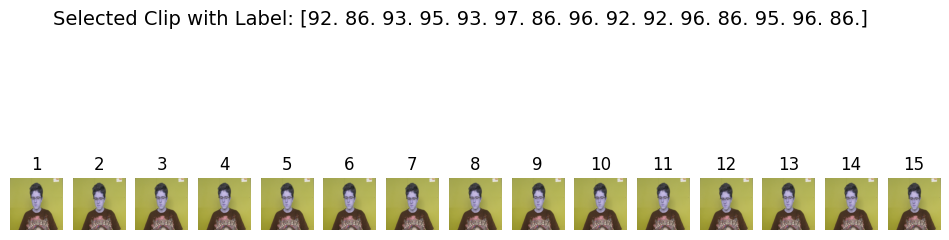

KeyboardInterrupt: ignored

In [4]:
import torch
import numpy as np

# Assuming you have a DataLoader named 'data_loader' that provides batches of video data and labels
# Now you can access the video frames from the dataset and convert them into a tensor
for clip, clip_labels in (data_loader):
  # print(clip_labels)
  print("Number of frames in clip:", len(clip))
  print("Number of labels in clip:", len(clip_labels))
  print("-----------------")

  # Now you can process each clip along with its labels
  # 'video_data' is already a batch of video frames (a list of tensors)
  video_tensor = torch.stack(clip)
  print(video_tensor.shape, (torch.stack(clip_labels)).shape)
  break  # Break after the first batch

In [ ]:
# Print the number of samples in the dataset
print("Number of samples in the dataset:", len(dataset))

# Print the number of batches in the data loader
num_batches = len(data_loader)
print("Number of batches in the data loader:", num_batches)

test = 0
# Print the shape of each video tensor in the first batch
for batch_data, batch_labels in data_loader:
    # batch_data is a list of video tensors, so we need to access the shape of each tensor
    for video_tensor in batch_data:
        print("Video tensor shape:", video_tensor.shape)
    print("Batch labels:", batch_labels)
    test+=1
    if test == 3:
      break  # Stop after the first batch to avoid printing all batches

## ResNet18 Model_1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

import torch
import torch.nn as nn
import torchvision.models as models

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # B, HW, C'
        key = self.key(x).view(batch_size, -1, width * height)  # B, C', HW
        value = self.value(x).view(batch_size, -1, width * height)  # B, C, HW

        attention = torch.matmul(query, key)  # B, HW, HW
        attention = nn.functional.softmax(attention, dim=1)

        weighted = torch.matmul(value, attention).view(batch_size, channels, height, width)

        out = self.gamma * weighted + x
        return out


class ResNet18_HeartRate(nn.Module):
    def __init__(self, num_classes, frame_length, dropout_prob=0.5):
        super(ResNet18_HeartRate, self).__init__()
        self.frame_length = frame_length
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

        resnet18 = models.resnet18(pretrained=False)
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.resnet18_features = nn.Sequential(*list(resnet18.children())[:-2])
        self.batch_norm = nn.BatchNorm2d(512)
        self.temporal_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.attention = SelfAttention(512)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, frame_length)
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, x):
        # print('A', x.shape)
        num_clips, batch_size, frames, height, width, channels = x.size()

        # Reshape input to (batch_size * num_clips * frames, channels, height, width)
        x = x.view(-1, channels, height, width)
        # print('AA', x.shape)

        features = self.resnet18_features(x)
        features = self.batch_norm(features)
        features = self.attention(features)


        pooled_features = self.temporal_pooling(features).view(batch_size * num_clips, frames, -1)

        x = self.fc1(pooled_features)
        x = self.dropout(x)
        intermediate_predictions = self.fc2(x)  # Intermediate predictions with shape [batch_size * num_clips, frames, 32]

        # Introduce an additional fully connected layer to map [32, 32] to [32]
        intermediate_predictions = intermediate_predictions.mean(dim=1)
        predictions = intermediate_predictions.view(num_clips, batch_size, frames)
        # print('AAAA', predictions.shape)

        return predictions



# Example usage:
num_classes = 1
num_clips = 1

# Create an instance of the ResNet18_HeartRate model
model = ResNet18_HeartRate(num_classes, frame_length)

# Sample input tensor with shape (num_clips, batch_size, frames, channels, height, width)
sample_input = torch.randn(num_clips, batch_size, frame_length, 224, 224, 3)

# Forward pass to get heart rate predictions
predictions = model(sample_input)

# The 'predictions' tensor will have shape (batch_size, frames)
print(predictions.shape)
print(predictions)


##Training Loop and Validation
At first tried using trainX, trainY, testX, testY form but failed thus Excludeded Subject 8,9,17,23,29,31 for training purposes

Running the model for just 10 frames to prevent overfitting since this Model_1 returns predictions frame-wise not clip-wise

Try 1 Executing (6h 08m 31s)  <cell line: 90> navigate_next _call_impl() navigate_next forward() navigate_next _call_impl() navigate_next forward() ... navigate_next _conv_forward() --- Session Crashed on 11-08-2023

Try 2 Executing (5h 37m 19s) <cell line: 12> navigate_next __next__() navigate_next _next_data() navigate_next fetch() navigate_next <listcomp> navigate_next __getitem__() navigate_next _load_video() --- Session Crashed on 12-08-2023

Try 3 Executing 3h 59m 10s completed at 11:58 AM -- Session Crashed on 14-08-2023

Try 4 error 2h 48m 48s completed at 2:34 AM on 15-08-2023 -- System Busy because of all RAM used up

Try 5 error 4h 34m 58s completed at 7:33 AM on 15-08-2023 -- 40 % Completed (Saving the model at every time instatn inside the loop from now ownwards)

**Try 6 check 1h 52m 21s completed at 4:37 PM on 15-08-2023 (with reduced iterations)**

In [ ]:
# import random

# # List to store training and testing batches
# train_batches = []
# test_batches = []

# # Loop through the data loader to create training and testing batches
# for batch in data_loader:
#     # Shuffle the batch to distribute videos for training and testing
#     batch = random.shuffle(batch)

#     # Split the shuffled batch into training and testing videos
#     train_batch = batch[:num_train_videos]
#     test_batch = batch[num_train_videos:num_train_videos + num_test_videos]

#     # Append the batches to the corresponding lists
#     train_batches.append(train_batch)
#     test_batches.append(test_batch)
#     break

In [1]:
# Define Mean Squared Error (MSE) loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_classes = 1
num_clips = 1

# Training and validation loop
num_epochs = 5  # Example number of epochs, adjust as needed
validation_frequency = 4  # Perform validation every 3 epochs
best_validation_loss = float('inf')  # Initialize with a large value

batch_losses_per_epoch = []
batch_loss = []
validation_losses = []
predicted_values = []
true_values = []

for epoch in range(num_epochs):
    for batch_index, (video_clips, batch_labels) in enumerate(data_loader):
      if video_clips != 0 and batch_labels != 0:
        # Convert the lists to tensors
        video_clips = torch.stack(video_clips)
        # print(video_clips.shape, video_clips)
        batch_labels = torch.stack(batch_labels)
        # print(batch_labels.shape, batch_labels)

        optimizer.zero_grad()

        # Forward pass to get heart rate predictions
        predictions = model(video_clips)
        predicted_values.append((epoch, batch_index, predictions))
        true_values.append((epoch, batch_index, batch_labels))


        # Convert batch_labels to a tensor with appropriate dimensions and data type
        batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.float32)
        print("Predictions Vector Shape: ", predictions.shape)
        print("Batch Labels Shape: ", batch_labels.shape)

        # Compute the loss using Mean Squared Error (MSE) loss
        loss = loss_fn(predictions, batch_labels_tensor)

        if model.training:
            # Backward pass and update model parameters only during training
            loss.backward()
            optimizer.step()

            batch_loss.append((epoch, batch_index, loss.item()))  # Store batch loss with epoch and batch index
            batch_losses_per_epoch.append((epoch, loss.item()))  # Store batch loss for the current epoch

            # Print the loss at the end of each batch
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

        # Perform validation step every 'validation_frequency' epochs
        if (epoch + 1) % validation_frequency == 0:
            model.eval()  # Switch to evaluation mode
            with torch.no_grad():
                validation_loss = 0.0
                num_batches = 0

                try:
                  for val_video_clips, val_batch_labels in data_loader:  # Use validation data_loader
                    if video_clips is not None and batch_labels is not None:
                      val_video_clips = torch.stack(val_video_clips)
                      val_batch_labels = torch.stack(val_batch_labels)

                      # Forward pass to get validation predictions
                      val_predictions = model(val_video_clips)

                      # Convert validation batch_labels to a tensor with appropriate dimensions and data type
                      val_batch_labels_tensor = torch.tensor(val_batch_labels, dtype=torch.float32)

                      # Compute validation loss using Mean Squared Error (MSE) loss
                      val_loss = loss_fn(val_predictions, val_batch_labels_tensor)

                      # Accumulate validation loss
                      validation_loss += val_loss.item()
                      num_batches += 1
                    else:
                      print("Not enough frames for sampling. Skipping this batch...")

                except ValueError as e:
                    print("Error:", e)
                    continue

                # Calculate average validation loss
                average_validation_loss = validation_loss / num_batches
                validation_losses.append((epoch+1, average_validation_loss))

                # Print validation loss
                print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {average_validation_loss}")

                # Update best validation loss and save model checkpoint if validation loss improves
                if average_validation_loss < best_validation_loss:
                    best_validation_loss = average_validation_loss
                    torch.save(model.state_dict(), '/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 2 11-08-2023/model_1.pth')

            model.train()  # Switch back to training model
      else:
        print("Not enough frames for sampling. Skipping this batch...")


# Training completed
torch.save(model.state_dict(), '/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 2 11-08-2023/model_1.pth')

NameError: ignored

Due to multiple failed attempts the above attempt was run for a very limited number of iterations especially batch_size was increased to decrease iterations of Validation_loop. Here's the details of running parameters:

> ***Num_Vidoes = 36,  Batch_Size = 6,  num_epoch = 5,  Validation_frequency = 4,  Frame_length = 15***



### Saving Model_1

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 2 11-08-2023/model_1.pth')

## Results

<ipython-input-13-f07c8f08d719>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(epoch_batch_indices, rotation=45, ha='right')


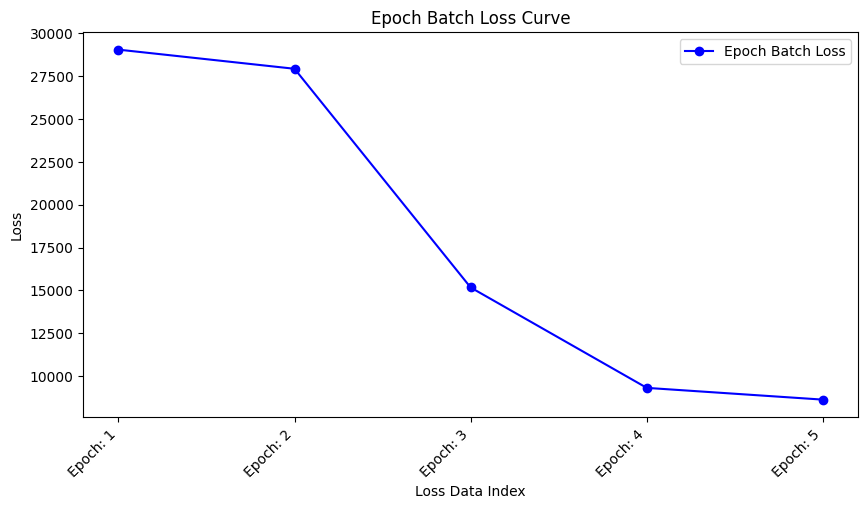

<ipython-input-13-f07c8f08d719>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(batch_indices, rotation=45, ha='right')


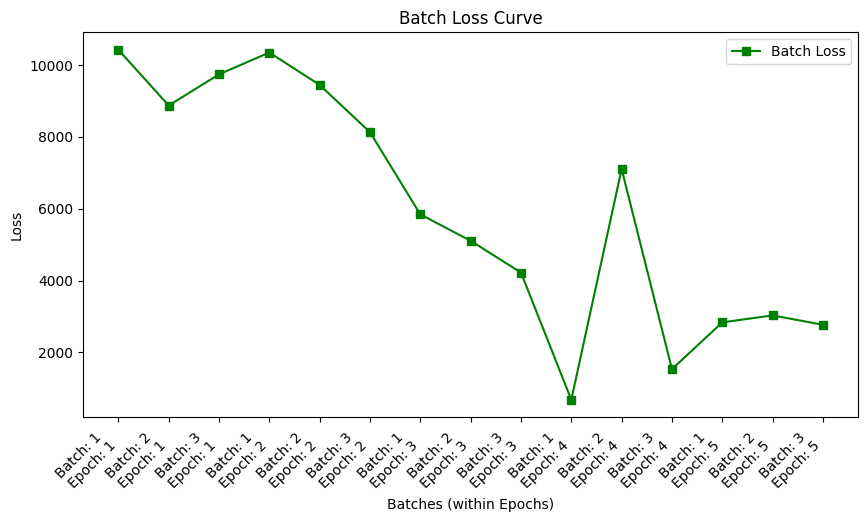

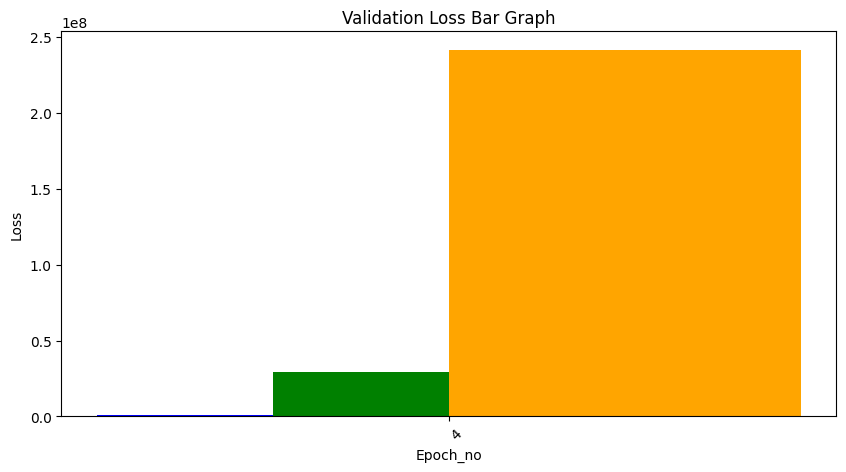

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# print(batch_losses_per_epoch, '\n')
# print(batch_loss, '\n')
# print(validation_losses, '\n')

# Calculate batch indices for batch_losses_per_epoch
epoch_batch_indices = [f'Epoch: {epoch+1}'  for epoch in range(num_epochs)]
epoch_batch_losses = [sum(loss for epoch_val, loss in batch_losses_per_epoch if epoch_val == epoch) for epoch in range(num_epochs)]
# Plot epoch_batch_loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epoch_batch_indices, epoch_batch_losses, marker='o', linestyle='-', color='blue', label='Epoch Batch Loss')
ax.set_xlabel('Loss Data Index')
ax.set_ylabel('Loss')
ax.set_title('Epoch Batch Loss Curve')
ax.set_xticklabels(epoch_batch_indices, rotation=45, ha='right')
# ax.set_ylim(min(epoch_batch_losses) - 10, max(epoch_batch_losses) + 10)
plt.legend()
plt.show()


# Calculate batch indices for batch_loss
batch_indices = [f'Batch: {batch_index+1} \nEpoch: {epoch+1}' for epoch, batch_index, _ in batch_loss]
batch_losses = [loss for _ , _ , loss in batch_loss]
# Plot batch_loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(batch_indices, batch_losses, marker='s', linestyle='-', color='green', label='Batch Loss')
ax.set_xlabel('Batches (within Epochs)')
ax.set_ylabel('Loss')
ax.set_title('Batch Loss Curve')
ax.set_xticklabels(batch_indices, rotation=45, ha='right')
# ax.set_ylim(min(batch_losses) - 10, max(batch_losses) + 10)
plt.legend()
plt.show()


# Calculate validation indices for validation_losses
def val_loss_calc(validation_losses):
    loss_groups = {}  # Dictionary to store grouped losses
    for x, loss in validation_losses:
        if x not in loss_groups:
            loss_groups[x] = []
        loss_groups[x].append(loss)
    grouped_losses = [losses for x, losses in loss_groups.items()]
    x_values = list(loss_groups.keys())
    return grouped_losses, x_values
validation_loss, validation_indices = val_loss_calc(validation_losses)

# Plot validation_losses
fig, ax = plt.subplots(figsize=(10, 5))
bar_colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'magenta', 'yellow']
num_entries = len(validation_indices)
x_ticks = np.arange(num_entries)  # Create ticks for x-axis
bar_width = 0.1  # Width of each bar

# Plot the bars for each entry
for i, y_values in enumerate(validation_loss):
    x_positions = x_ticks[i] + np.linspace(-bar_width/2, bar_width/2, len(y_values))
    ax.bar(x_positions, y_values, bar_width, label=f'Entry {i+1}', color=bar_colors[i::num_entries])

ax.set_xticks(x_ticks)
ax.set_xticklabels(validation_indices)
ax.set_xlabel('Epoch_no')
ax.set_ylabel('Loss')
ax.set_title('Validation Loss Bar Graph')
ax.set_xticklabels(validation_indices, rotation=45, ha='left')
# # ax.set_ylim(min(validation_loss) - 10, max(validation_loss) + 10)
plt.show()

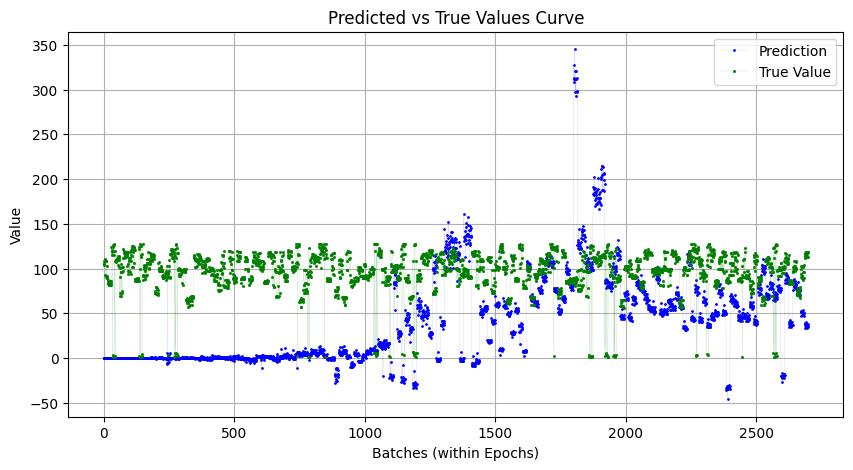

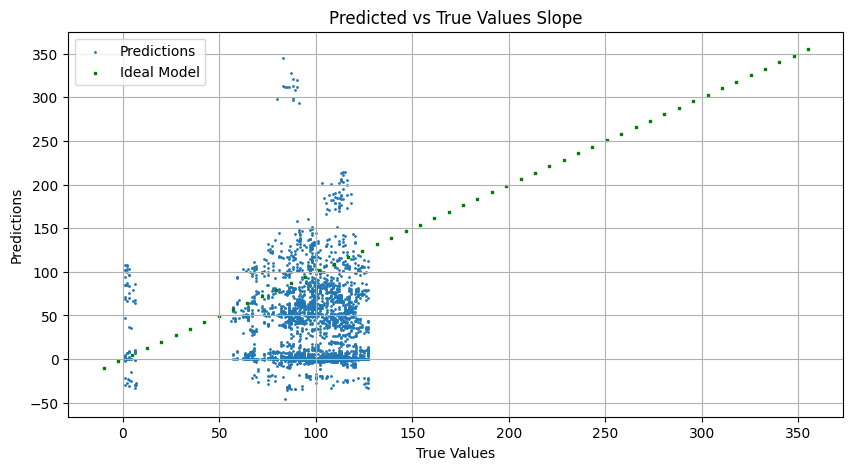

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Access the predicted values and true values at the chosen index
chosen_predicted_values = [predictions.detach().numpy() for epoch, batch_index, predictions in predicted_values]
chosen_true_values = [batch_labels.detach().numpy() for epoch, batch_index, batch_labels in true_values]
chosen_indices = [f'Batch: {batch_index+1} \nEpoch: {epoch+1}' for epoch, batch_index, _ in predicted_values]
chosen_predicted_values = np.array(chosen_predicted_values)
chosen_true_values = np.array(chosen_true_values)
chosen_indices = np.array(chosen_indices)

# print(chosen_predicted_values)
# print(chosen_true_values)
# print(chosen_indices.shape, chosen_indices)

# Plot Predicted vs True Values Curve
fig, ax = plt.subplots(figsize=(10, 5))
# for color_index in range(chosen_predicted_values.shape[2]):
#     ax.plot(chosen_predicted_values[:, :, color_index].flatten(), marker='o', linestyle='-', label=f'Predicted Color {color_index+1}')
#     ax.plot(chosen_true_values[:, :, color_index].flatten(), marker='s', linestyle='-', label=f'True Color {color_index+1}')

ax.plot(chosen_predicted_values.flatten(), marker='o', linestyle='-', color = 'blue', label = 'Prediction', markersize=1, linewidth=0.05)
ax.plot(chosen_true_values.flatten(), marker='s', linestyle='-', color = 'green', label = 'True Value', markersize=1, linewidth=0.05)
ax.set_xlabel('Batches (within Epochs)')
ax.set_ylabel('Value')
ax.set_title('Predicted vs True Values Curve')
# ax.set_xticklabels(chosen_indices, rotation=45, ha='right')
# ax.set_ylim(min(epoch_batch_losses) - 10, max(epoch_batch_losses) + 10)
plt.grid()
plt.legend()
plt.show()


# Plot Predicted vs True Values Slope
common_axis_min = -10
common_axis_max = max(max(chosen_predicted_values.flatten()), max(chosen_true_values.flatten())) + 10
x = np.linspace(common_axis_min, common_axis_max)
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(chosen_true_values.flatten(), chosen_predicted_values.flatten(), marker='o', linestyle='-', s = 1, label = 'Predictions')
ax.scatter(x, x, marker='s', linestyle='solid', color = 'green', s = 0.9, label = 'Ideal Model')
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')
ax.set_title('Predicted vs True Values Slope')
# plt.xlim(common_axis_min, common_axis_max)
# plt.ylim(common_axis_min, common_axis_max)
plt.grid()
plt.legend()
plt.show()

## Testing Model_1
Comments: Horrible Prediction

> Transfer Learning Implemented to test over updated frame_size



In [ ]:
excluded_directory_testSet = [
        "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject8",
        "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject9",
        "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject17",
        "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject23",
        "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject27",
        "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject31"
    ]


frame_length_new = 25
pixel_size = 224
batch_size = 36
num_classes = 1
num_clips = 1

In [ ]:
import torch
import torch.nn as nn

# Load the saved model's state dictionary
model_state_dict = torch.load('/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 2 11-08-2023/model_1.pth')

# Define the new frame length
frame_length_new = 10  # Adjust this according to your needs

# Get the number of classes from the saved state dictionary
num_classes = model_state_dict['fc2.bias'].shape[0]
# print(num_classes)

# Create a new instance of the ResNet18_HeartRate model with the new frame length
model_new = ResNet18_HeartRate(num_classes, frame_length_new)

# Load the weights and biases from the saved model's state dictionary
# Adjust the keys in the state dictionary to match the new model's architecture
new_state_dict = {}
# print(np.array(model_state_dict))
for key, value in model_state_dict.items():
    if 'fc2' in key:
        # Replace the last fully connected layer's weights and biases
        new_state_dict[key] = model_new.state_dict()[key]
    else:
        new_state_dict[key] = value
# print(new_state_dict)
# Load the modified state dictionary into the new model
model_new.load_state_dict(new_state_dict)

# Set the new model in evaluation mode
model_new.eval()

# Now you can use the model_new with the adjusted frame length


ResNet18_HeartRate(
  (resnet18_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

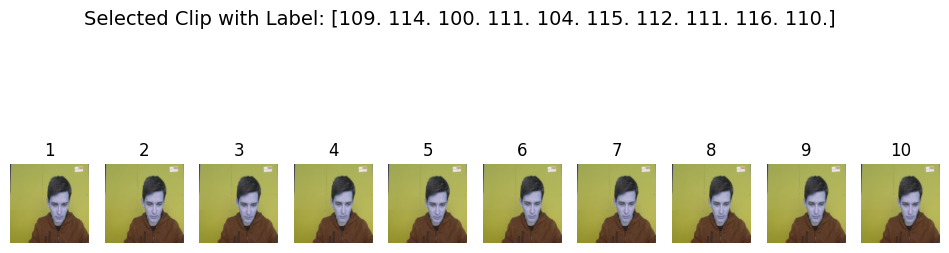

<ipython-input-11-1ca58959fe7a>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.float32)


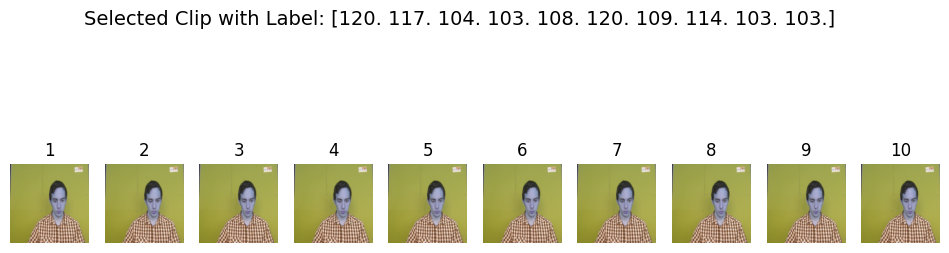

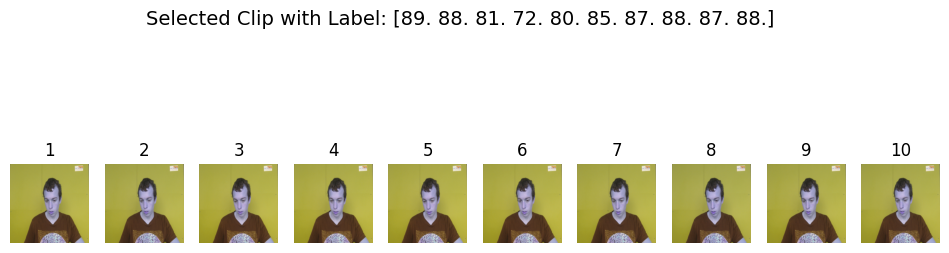

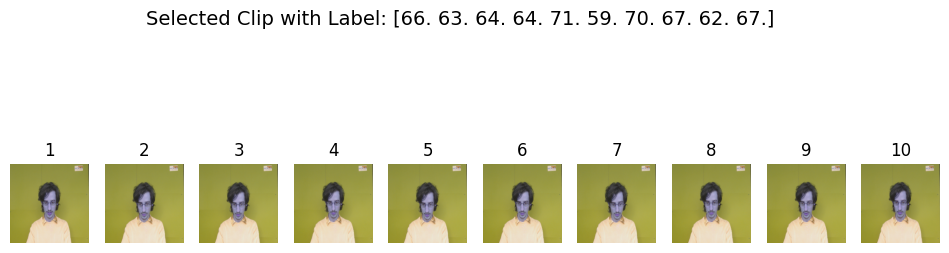

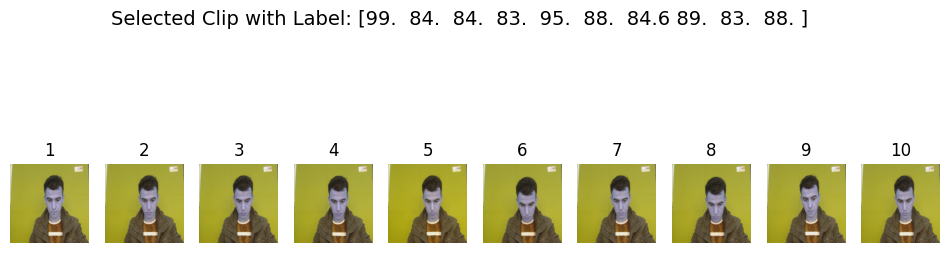

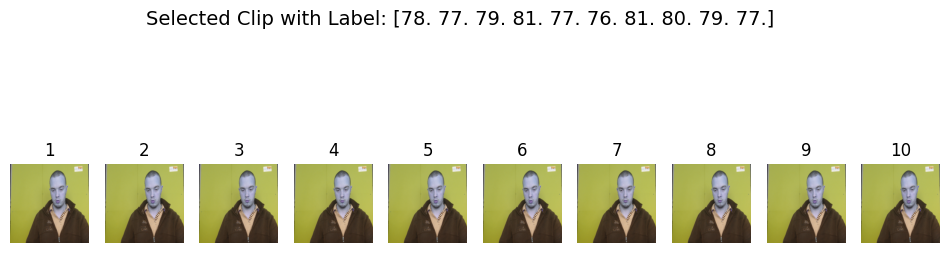

Average Evaluation Loss: 44238.203776041664


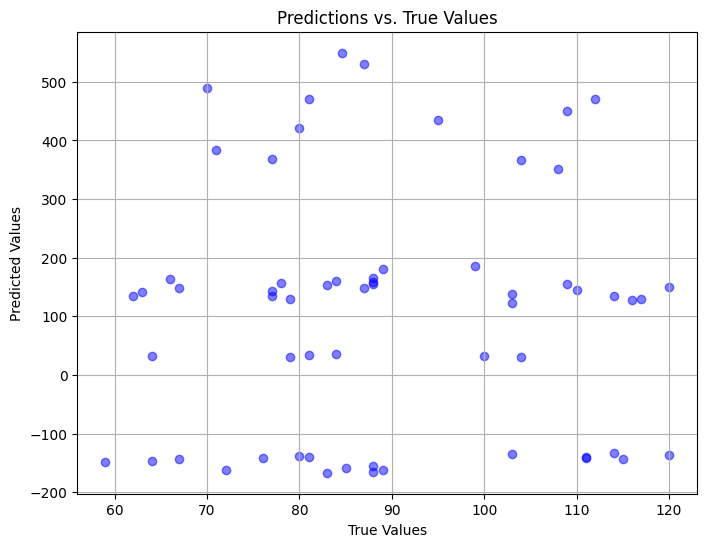

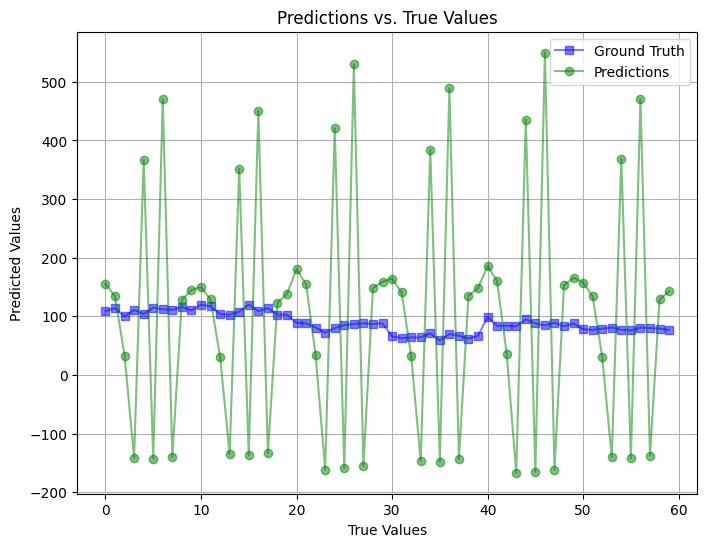

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# # Load the saved model's state dictionary
# model_state_dict = torch.load('/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 2 11-08-2023/model_1.pth')
# model_new = ResNet18_HeartRate(num_classes, frame_length_new)  # Assuming frame_length_new is the desired new frame length
# model_new.load_state_dict(model_state_dict)
# model_new.eval()  # Set the model in evaluation mode

# Define Mean Squared Error (MSE) loss function
loss_fn = nn.MSELoss()

# Define a list to store evaluation losses
evaluation_losses = []

# Define lists to store predicted and true values for visualization
predicted_values = []
true_values = []

# Loop through the list of directories for evaluation
for directory_path in excluded_directory_testSet:
    test_dataset = HeartRateDataset(directory_path, frame_length_new, pixel_size)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        for video_clips, batch_labels in test_data_loader:
            if video_clips is not None and batch_labels is not None:
                video_clips = torch.stack(video_clips)
                batch_labels = torch.stack(batch_labels)

                # Forward pass to get predictions
                predictions = model_new(video_clips)

                # Convert batch_labels to a tensor with appropriate dimensions and data type
                batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.float32)

                # Compute the loss using Mean Squared Error (MSE) loss
                loss = loss_fn(predictions, batch_labels_tensor)

                # Accumulate evaluation loss
                evaluation_losses.append(loss.item())

                # Store predicted and true values for visualization
                predicted_values.extend(predictions.tolist())
                true_values.extend(batch_labels.tolist())

# Calculate average evaluation loss
average_evaluation_loss = sum(evaluation_losses) / len(evaluation_losses)

# Print the results
print(f"Average Evaluation Loss: {average_evaluation_loss}")

# Visualize predictions vs. true values using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predicted_values, color='blue', marker='o', alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs. True Values")
plt.grid(True)
plt.show()

true_values_array = np.array(true_values)
predicted_values_array = np.array(predicted_values)
# Visualize predictions vs. true values using a scatter plot
plt.figure(figsize=(8, 6))
plt.plot(true_values_array.flatten(), color='blue', marker='s', alpha=0.5, label = 'Ground Truth')
plt.plot(predicted_values_array.flatten(), color='green', marker='o', alpha=0.5, label = 'Predictions')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs. True Values")
plt.grid(True)
plt.legend()
plt.show()

## Cheat Sheet

['Epoch 1\nBatch 1', 'Epoch 1\nBatch 2', 'Epoch 1\nBatch 3', 'Epoch 1\nBatch 4', 'Epoch 2\nBatch 1', 'Epoch 2\nBatch 2', 'Epoch 2\nBatch 3', 'Epoch 2\nBatch 4']


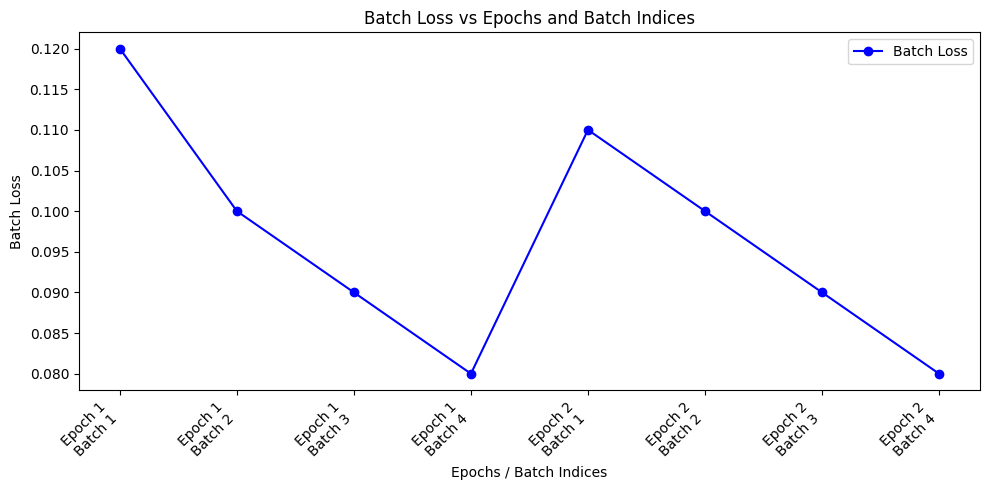

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x_axis = [[1, 1], [1, 2], [1, 3], [1, 4], [2, 1], [2, 2], [2, 3], [2, 4]]
validation_losses = [0.1, 0.08, 0.06, 0.05, 0.04, 0.07, 0.09, 0.08]
batch_losses = [0.12, 0.1, 0.09, 0.08, 0.11, 0.1, 0.09, 0.08]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot batch losses
x_positions = list(range(1, len(x_axis) + 1))
ax.plot(x_positions, batch_losses, marker='o', linestyle='-', color='blue', label='Batch Loss')

# Set labels and title
ax.set_xlabel('Epochs / Batch Indices')
ax.set_ylabel('Batch Loss')
ax.set_title('Batch Loss vs Epochs and Batch Indices')

# Set custom x-axis labels
x_labels = [f'Epoch {epoch}\nBatch {batch}' for epoch, batch in x_axis]

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

plt.legend()
plt.tight_layout()
plt.show()


Grouped Losses: [[1, 3], [12, 9]]
X Values: [2, 4]


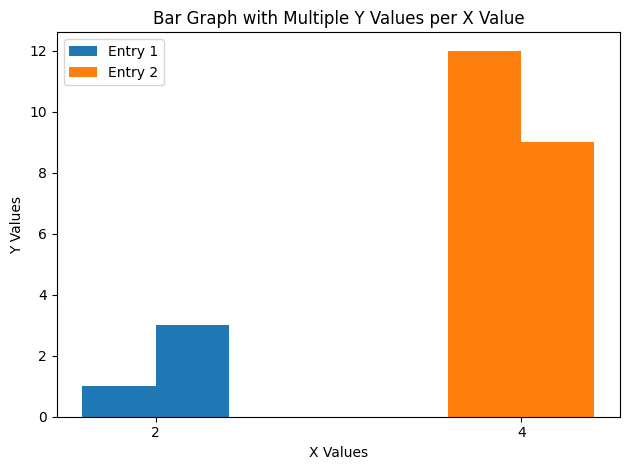

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def group_losses(validation_losses):
    loss_groups = {}  # Dictionary to store grouped losses

    # Group the losses based on x-values
    for x, loss in validation_losses:
        if x not in loss_groups:
            loss_groups[x] = []
        loss_groups[x].append(loss)

    # Convert the grouped losses dictionary into a list of lists
    grouped_losses = [losses for x, losses in loss_groups.items()]

    # Get the x_values list from the keys of the loss_groups dictionary
    x_values = list(loss_groups.keys())

    return grouped_losses, x_values

# Example validation_losses data
validation_losses = [(2, 1), (2, 3), (4, 12), (4, 9)]

# Call the function to get the desired result
grouped_losses, x_values = group_losses(validation_losses)
print("Grouped Losses:", grouped_losses)
print("X Values:", x_values)



# Prepare data for plotting
num_entries = len(x_values)
x_ticks = np.arange(num_entries)  # Create ticks for x-axis
bar_width = 0.2  # Width of each bar

fig, ax = plt.subplots()

# Plot the bars for each entry
for i, y_values in enumerate(grouped_losses):
    x_positions = x_ticks[i] + np.linspace(-bar_width/2, bar_width/2, len(y_values))
    ax.bar(x_positions, y_values, bar_width, label=f'Entry {i+1}')

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_values)
ax.set_xlabel('X Values')
ax.set_ylabel('Y Values')
ax.set_title('Bar Graph with Multiple Y Values per X Value')
ax.legend()

plt.tight_layout()
plt.show()
